### **Libraries**

In [1]:
!pip install scikit-optimize
!pip install catboost
!pip install prince


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 2.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import copy
# import prince


## Data

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# df=pd.read_csv('/content/sample_submission.csv')
tr=pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")


In [5]:
tr.shape

(3116945, 22)

In [6]:
tr.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [7]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [8]:
df_train = copy.deepcopy(tr)

# **Category**

In [9]:
def subclass_details (df):
  df=df.select_dtypes(include='category')
  for col in df.columns:
    print('Number of unique classes:',df[col].nunique())
    print(df[col].value_counts().head(10))
    print('############################')

In [10]:
def remove_att(df,threshold=200):
  cat_coln=df.select_dtypes(include='object')
  for col in cat_coln:
    attrib_drop=[]
    for att , count in df[col].value_counts().items() :
      if count <threshold:
        attrib_drop.append(att)
    mask = df[col].isin(attrib_drop)
    df.loc[mask,col] = 'UNK'
  return df

In [11]:
def convert_cate (df):
  for clas in df.select_dtypes(include='object'):
    df[clas] =   df[clas].astype('category')
  return df

In [12]:
df_train = remove_att(df_train,60)
df_train = convert_cate(df_train)
subclass_details(df_train)

Number of unique classes: 2
class
p    1705396
e    1411549
Name: count, dtype: int64
############################
Number of unique classes: 10
cap-shape
x      1436026
f       676238
s       365146
b       318646
o       108835
p       106967
c       104520
UNK        402
d           65
e           60
Name: count, dtype: int64
############################
Number of unique classes: 14
cap-surface
t    460777
s    384970
y    327826
h    284460
g    263729
d    206832
k    128875
e    119712
i    113440
w    109840
Name: count, dtype: int64
############################
Number of unique classes: 13
cap-color
n    1359542
y     386627
w     379442
g     210825
e     197290
o     178847
p      91838
r      78236
u      73172
b      61313
Name: count, dtype: int64
############################
Number of unique classes: 3
does-bruise-or-bleed
f      2569743
t       547085
UNK        109
Name: count, dtype: int64
############################
Number of unique classes: 9
gill-attachment
a      6

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   class                 category
 2   cap-diameter          float64 
 3   cap-shape             category
 4   cap-surface           category
 5   cap-color             category
 6   does-bruise-or-bleed  category
 7   gill-attachment       category
 8   gill-spacing          category
 9   gill-color            category
 10  stem-height           float64 
 11  stem-width            float64 
 12  stem-root             category
 13  stem-surface          category
 14  stem-color            category
 15  veil-type             category
 16  veil-color            category
 17  has-ring              category
 18  ring-type             category
 19  spore-print-color     category
 20  habitat               category
 21  season                category
dtypes: category(18), f

# **Missing Value**

In [14]:
def plot_missing_feature(df):
  null_df=(df.isna().sum()*100/df.shape[0]).sort_values(ascending=False)
  sns.barplot(x=null_df.index,y=null_df.values,palette='plasma')
  plt.xticks(rotation=90)
  plt.xlabel('Feature')
  plt.ylabel('Percent(%)')
  plt.title('Missing Values')
  plt.show()

In [15]:
def missing_feature (df):
  null_df=(df.isna().sum()*100/df.shape[0]).sort_values(ascending=False)
  return null_df

In [16]:
null_df_train = missing_feature(df_train)
null_df_train

veil-type               94.884350
spore-print-color       91.425482
stem-root               88.452732
veil-color              87.936970
stem-surface            63.551362
gill-spacing            40.373988
cap-surface             21.528227
gill-attachment         16.809280
ring-type                4.134818
gill-color               0.001829
habitat                  0.001444
cap-shape                0.001283
stem-color               0.001219
has-ring                 0.000770
cap-color                0.000385
does-bruise-or-bleed     0.000257
cap-diameter             0.000128
id                       0.000000
stem-width               0.000000
class                    0.000000
stem-height              0.000000
season                   0.000000
dtype: float64

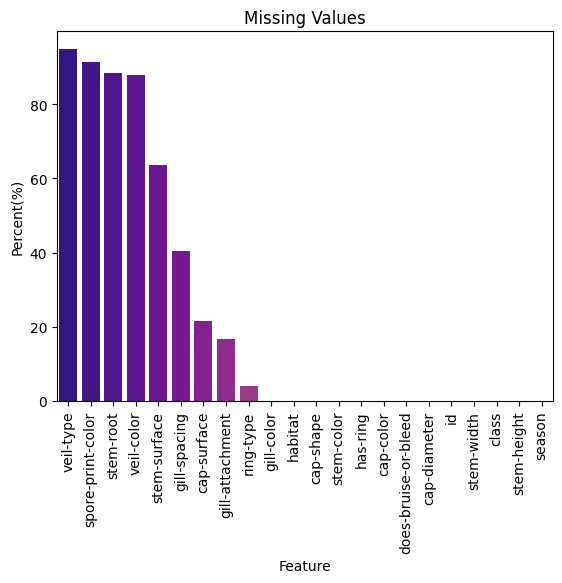

In [17]:
plot_missing_feature(df_train)

In [18]:
def columns_drop(df):
  column_drop=[]
  null_df=missing_feature(df)
  for col,val in null_df.items():
    if val >4:
      column_drop.append(col)
  return column_drop

In [19]:
column_drop_train = columns_drop(df_train)
print('-----------------------------------------')
print(column_drop_train)

-----------------------------------------
['veil-type', 'spore-print-color', 'stem-root', 'veil-color', 'stem-surface', 'gill-spacing', 'cap-surface', 'gill-attachment', 'ring-type']


In [20]:
df_train.drop(column_drop_train,axis=1,inplace=True)
df_train.drop('id',axis=1,inplace=True)

In [21]:
df_train.isna().sum()

class                    0
cap-diameter             4
cap-shape               40
cap-color               12
does-bruise-or-bleed     8
gill-color              57
stem-height              0
stem-width               0
stem-color              38
has-ring                24
habitat                 45
season                   0
dtype: int64

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

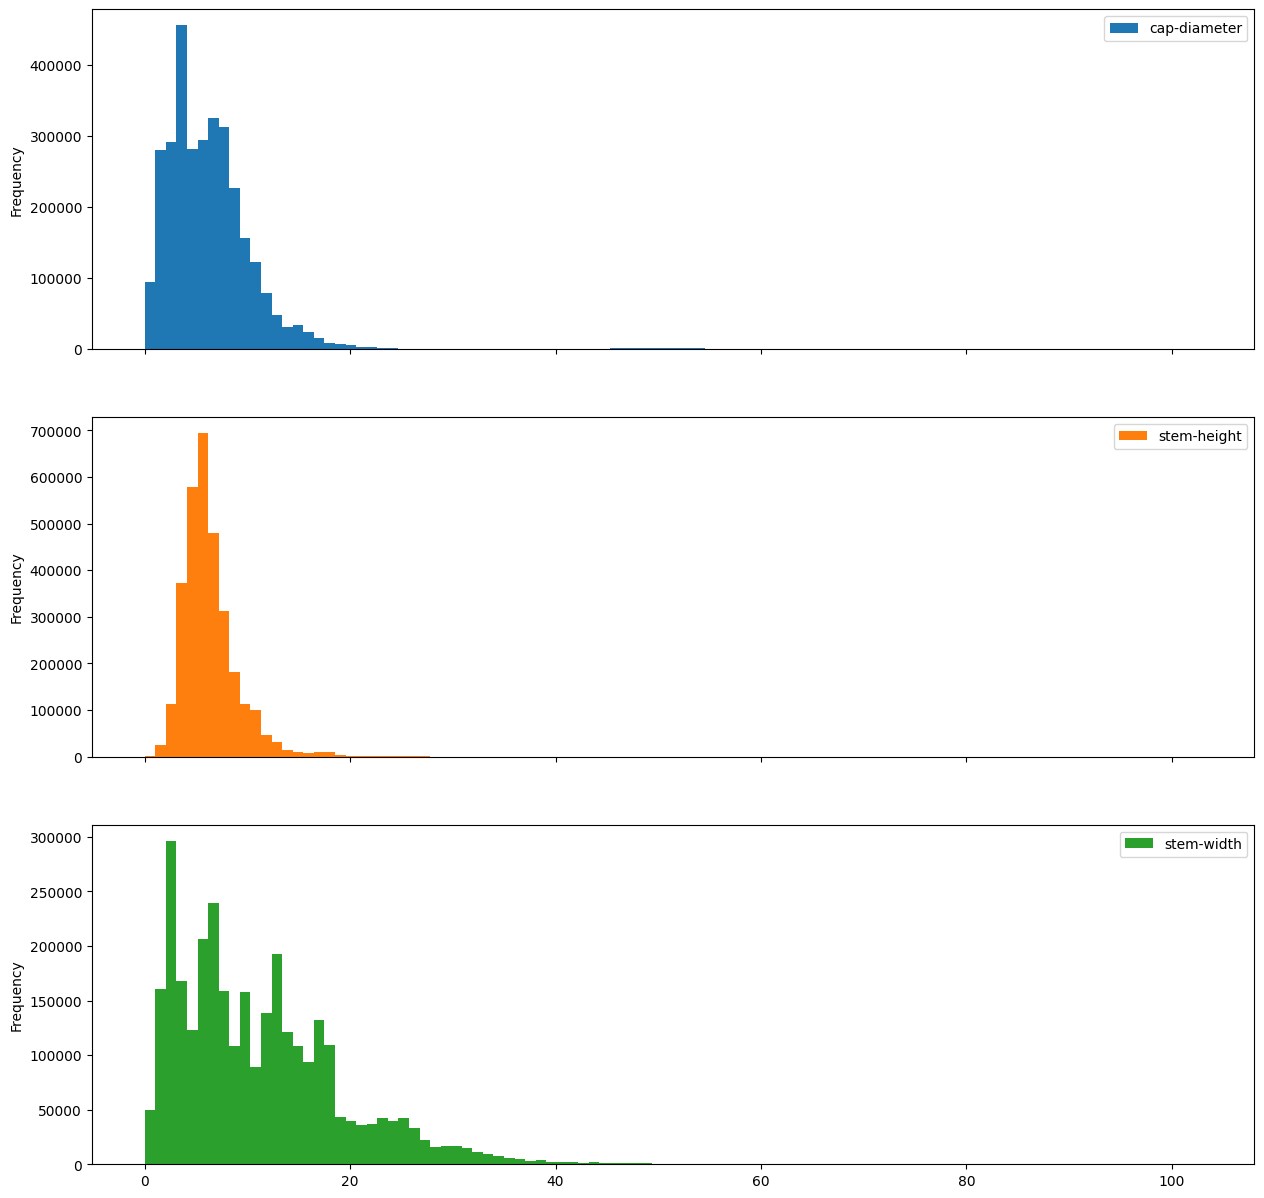

In [22]:
df_train.plot(kind='hist',subplots=True,sharex=True,figsize=(15,15),bins=100)

# **Splitting Data**

In [23]:
x=df_train.drop('class',axis=1)
y=df_train['class']
y=np.array([0 if i =='e' else 1 for i in y])
y.reshape(-1,1)

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [24]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=.7,stratify=y)

# **Pipeline**

In [25]:
num_data_train_columns = x.select_dtypes(include='number').columns
cat_data_train_columns = x.select_dtypes(include='category').columns
cat_data_train_columns

Index(['cap-shape', 'cap-color', 'does-bruise-or-bleed', 'gill-color',
       'stem-color', 'has-ring', 'habitat', 'season'],
      dtype='object')

In [26]:
num_pipe=Pipeline (steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])
cat_pipe=Pipeline (steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(sparse=False, handle_unknown='ignore'))
    # ('encoder',OrdinalEncoder())

])

In [27]:
df_preprocessing=ColumnTransformer(
     transformers=[
        ('num', num_pipe, num_data_train_columns),
        ('cat', cat_pipe, cat_data_train_columns)
    ]
)

In [28]:
final_pipe = Pipeline(steps=[
    ('preprocessor',df_preprocessing),
    ('PCA',PCA(n_components=.95)),
#     ('MCA',prince.MCA( n_components=2,  n_iter=3,       check_input=True, engine='auto',   random_state=42))

])

In [29]:
x_train=final_pipe.fit_transform(x_train)
x_test=final_pipe.transform(x_test)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# **Modeling**

In [30]:
def Bayesian_Optimization (model,search_space):
  bayes = BayesSearchCV(model,
                        search_space,
                         n_iter= 10,
                        n_jobs=-1,
                        scoring='accuracy',
                        random_state=42)
  return bayes

In [31]:
xgb_space = {
    'n_estimators': Integer(50, 150),
    'max_depth': Integer(2, 8),
    'learning_rate': Real(0.01, .4, 'log-uniform'),
    'subsample': Real(0.5, 1.0, 'uniform'),
    'colsample_bytree': Real(0.5, 1.0, 'uniform'),
    'alpha':Real(.1,.5,'uniform'),
    'min_child_weight':Integer(5,10)
}
lgb_space={'num_leaves': Integer(24, 45),
          'feature_fraction': Real(0.1, 0.9),
          'bagging_fraction': Real(0.5, 1),
          'max_depth':Integer (5, 9),
          'lambda_l1':Real (0, 5),
          'lambda_l2':Real (0, 3),
          'min_split_gain':Real (0.001, 0.1),
          'min_child_weight': Integer(5, 60)
}
cat_space={
    'iterations': Integer(10, 100),
    'depth': Integer(1, 8),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'l2_leaf_reg': Real(1e-3, 10, 'log-uniform'),
    'border_count': Integer(32, 128)
}

In [32]:
clsss=len(y[y==0]) / len(y[y==1])
clsss

0.8276957375295826

In [33]:
xgb = XGBClassifier(random_state=42,scale_pos_weight =clsss)
# lgb = LGBMClassifier(random_state=42)
cat = CatBoostClassifier(random_state=42)
xgb_optimzied = Bayesian_Optimization(xgb,xgb_space)
# lgb_optimzied = Bayesian_Optimization(lgb,lgb_space)
cat_optimzied = Bayesian_Optimization(cat,cat_space)

In [34]:
xgb_optimzied.fit(x_train,y_train)
# lgb_optimzied.fit(x_train,y_train)
cat_optimzied.fit(x_train,y_train)

0:	learn: 0.6386376	total: 1.61s	remaining: 2m 29s
1:	learn: 0.6034150	total: 3.49s	remaining: 2m 40s
2:	learn: 0.5693600	total: 4.8s	remaining: 2m 25s
3:	learn: 0.5402996	total: 6.23s	remaining: 2m 20s
4:	learn: 0.5105272	total: 7.4s	remaining: 2m 11s
5:	learn: 0.4934633	total: 8.85s	remaining: 2m 9s
6:	learn: 0.4735484	total: 10.2s	remaining: 2m 7s
7:	learn: 0.4512656	total: 11.8s	remaining: 2m 7s
8:	learn: 0.4329659	total: 13.2s	remaining: 2m 4s
9:	learn: 0.4162615	total: 14.7s	remaining: 2m 3s
10:	learn: 0.4046276	total: 16.2s	remaining: 2m 1s
11:	learn: 0.3924613	total: 17.6s	remaining: 2m
12:	learn: 0.3809411	total: 19s	remaining: 1m 58s
13:	learn: 0.3707976	total: 20.3s	remaining: 1m 55s
14:	learn: 0.3628293	total: 21.7s	remaining: 1m 54s
15:	learn: 0.3515640	total: 23.2s	remaining: 1m 53s
16:	learn: 0.3418017	total: 24.6s	remaining: 1m 51s
17:	learn: 0.3335298	total: 26s	remaining: 1m 49s
18:	learn: 0.3254451	total: 27.7s	remaining: 1m 49s
19:	learn: 0.3160028	total: 29.3s	rema

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0:	learn: 0.6388107	total: 2.53s	remaining: 3m 55s
1:	learn: 0.6027037	total: 3.84s	remaining: 2m 56s
2:	learn: 0.5684364	total: 5.14s	remaining: 2m 35s
3:	learn: 0.5370060	total: 6.39s	remaining: 2m 23s
4:	learn: 0.5148680	total: 7.84s	remaining: 2m 19s
5:	learn: 0.4971434	total: 9.2s	remaining: 2m 14s
6:	learn: 0.4796482	total: 10.7s	remaining: 2m 12s
7:	learn: 0.4637673	total: 12.2s	remaining: 2m 10s
8:	learn: 0.4476393	total: 13.6s	remaining: 2m 8s
9:	learn: 0.4316918	total: 14.9s	remaining: 2m 5s
10:	learn: 0.4163979	total: 16.3s	remaining: 2m 2s
11:	learn: 0.4018363	total: 17.8s	remaining: 2m 1s
12:	learn: 0.3843563	total: 19.3s	remaining: 2m
13:	learn: 0.3745754	total: 20.8s	remaining: 1m 58s
14:	learn: 0.3650533	total: 22.2s	remaining: 1m 57s
15:	learn: 0.3504886	total: 23.6s	remaining: 1m 54s
16:	learn: 0.3403970	total: 24.9s	remaining: 1m 52s
17:	learn: 0.3307782	total: 26.3s	remaining: 1m 51s
18:	learn: 0.3222764	total: 27.8s	remaining: 1m 49s
19:	learn: 0.3141350	total: 29.

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


31:	learn: 0.1246999	total: 11.3s	remaining: 1.76s
32:	learn: 0.1232287	total: 11.6s	remaining: 1.41s
33:	learn: 0.1218132	total: 12s	remaining: 1.06s
34:	learn: 0.1190549	total: 12.4s	remaining: 706ms
35:	learn: 0.1176674	total: 12.7s	remaining: 352ms
36:	learn: 0.1159633	total: 13.1s	remaining: 0us
0:	learn: 0.6847103	total: 1.42s	remaining: 25.6s
1:	learn: 0.6759803	total: 2.83s	remaining: 24.1s
2:	learn: 0.6684044	total: 4.19s	remaining: 22.3s
3:	learn: 0.6601168	total: 5.6s	remaining: 21s
4:	learn: 0.6516015	total: 7.05s	remaining: 19.7s
5:	learn: 0.6445496	total: 8.43s	remaining: 18.3s
6:	learn: 0.6380001	total: 9.89s	remaining: 17s
7:	learn: 0.6308390	total: 11.4s	remaining: 15.7s
8:	learn: 0.6241878	total: 13.4s	remaining: 14.9s
9:	learn: 0.6176245	total: 14.9s	remaining: 13.4s
10:	learn: 0.6114163	total: 16.3s	remaining: 11.9s
11:	learn: 0.6055856	total: 17.8s	remaining: 10.4s
12:	learn: 0.5985765	total: 19.4s	remaining: 8.93s
13:	learn: 0.5929076	total: 20.8s	remaining: 7.42s

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0:	learn: 0.5537203	total: 2.33s	remaining: 55.9s
1:	learn: 0.4615245	total: 4.25s	remaining: 48.9s
2:	learn: 0.4166208	total: 5.51s	remaining: 40.4s
3:	learn: 0.3771453	total: 6.93s	remaining: 36.4s
4:	learn: 0.3460341	total: 8.45s	remaining: 33.8s
5:	learn: 0.3138598	total: 10.2s	remaining: 32.4s
6:	learn: 0.2813900	total: 11.8s	remaining: 30.4s
7:	learn: 0.2555158	total: 13.7s	remaining: 29.1s
8:	learn: 0.2366672	total: 15.4s	remaining: 27.3s
9:	learn: 0.2252908	total: 17s	remaining: 25.5s
10:	learn: 0.2128376	total: 18.6s	remaining: 23.7s
11:	learn: 0.2021074	total: 20.2s	remaining: 21.9s
12:	learn: 0.1940622	total: 21.8s	remaining: 20.1s
13:	learn: 0.1826011	total: 23.7s	remaining: 18.6s
14:	learn: 0.1732394	total: 25.5s	remaining: 17s
15:	learn: 0.1682524	total: 27s	remaining: 15.2s
16:	learn: 0.1633399	total: 28.5s	remaining: 13.4s
17:	learn: 0.1588328	total: 30.1s	remaining: 11.7s
18:	learn: 0.1532330	total: 31.7s	remaining: 10s
19:	learn: 0.1496330	total: 33.5s	remaining: 8.37

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


63:	learn: 0.3376922	total: 1m 26s	remaining: 32.6s
64:	learn: 0.3347555	total: 1m 28s	remaining: 31.2s
65:	learn: 0.3326281	total: 1m 29s	remaining: 29.8s
66:	learn: 0.3296933	total: 1m 30s	remaining: 28.4s
67:	learn: 0.3277482	total: 1m 31s	remaining: 27s
68:	learn: 0.3260625	total: 1m 33s	remaining: 25.6s
69:	learn: 0.3242057	total: 1m 34s	remaining: 24.3s
70:	learn: 0.3223974	total: 1m 35s	remaining: 22.9s
71:	learn: 0.3203239	total: 1m 36s	remaining: 21.5s
72:	learn: 0.3179466	total: 1m 38s	remaining: 20.2s
73:	learn: 0.3160868	total: 1m 39s	remaining: 18.9s
74:	learn: 0.3142948	total: 1m 40s	remaining: 17.5s
75:	learn: 0.3124441	total: 1m 42s	remaining: 16.1s
76:	learn: 0.3103284	total: 1m 43s	remaining: 14.8s
77:	learn: 0.3082663	total: 1m 45s	remaining: 13.5s
78:	learn: 0.3061511	total: 1m 46s	remaining: 12.2s
79:	learn: 0.3041294	total: 1m 48s	remaining: 10.8s
80:	learn: 0.3024623	total: 1m 49s	remaining: 9.48s
81:	learn: 0.3005930	total: 1m 50s	remaining: 8.1s
82:	learn: 0.29

BayesSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7d2323ac2740>,
              n_iter=10, n_jobs=-1, random_state=42, scoring='accuracy',
              search_spaces={'border_count': Integer(low=32, high=128, prior='uniform', transform='normalize'),
                             'depth': Integer(low=1, high=8, prior='uniform', transform='normalize'),
                             'iterations': Integer(low=10, high=100, prior='uniform', transform='normalize'),
                             'l2_leaf_reg': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=1.0, prior='log-uniform', transform='normalize')})

In [35]:
xgb_optimzied.best_params_

OrderedDict([('alpha', 0.4249583953429453),
             ('colsample_bytree', 0.5859357806982803),
             ('learning_rate', 0.0908044841973702),
             ('max_depth', 7),
             ('min_child_weight', 8),
             ('n_estimators', 60),
             ('subsample', 0.8779002664179407)])

In [36]:
xgb=xgb_optimzied.best_estimator_
# lgb=lgb_optimzied.best_estimator_
cat=cat_optimzied.best_estimator_

In [37]:
y_pred_xgb=xgb.predict(x_test)
# y_pred_lgm=lgb.predict(x_test)
y_pred_cat=cat.predict(x_test)
print('XGB --> ',accuracy_score(y_test,y_pred_xgb))
# print('LGM --> ',accuracy_score(y_test,y_pred_lgm))
print('CAT --> ',accuracy_score(y_test,y_pred_cat))

XGB -->  0.9640192752736653
CAT -->  0.9653100684002721


In [38]:
voting_clf=VotingClassifier(estimators=[
        ('xgb', xgb),
        ('catboost', cat)
#         ,('lightbgm',lbm)
    ],
    voting='soft'
)
voting_clf.fit(x_train,y_train)
y_pred_voting=voting_clf.predict(x_test)
print('Voting Classifier Accuracy',accuracy_score(y_test,y_pred_voting))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_voting))

0:	learn: 0.6365076	total: 432ms	remaining: 40.2s
1:	learn: 0.5989818	total: 807ms	remaining: 37.1s
2:	learn: 0.5622014	total: 1.21s	remaining: 36.7s
3:	learn: 0.5373144	total: 1.58s	remaining: 35.5s
4:	learn: 0.5112220	total: 1.95s	remaining: 34.7s
5:	learn: 0.4888998	total: 2.32s	remaining: 34.1s
6:	learn: 0.4672275	total: 2.79s	remaining: 34.7s
7:	learn: 0.4485917	total: 3.2s	remaining: 34.4s
8:	learn: 0.4298872	total: 3.64s	remaining: 34.3s
9:	learn: 0.4123043	total: 4.05s	remaining: 34s
10:	learn: 0.4000760	total: 4.5s	remaining: 33.9s
11:	learn: 0.3887014	total: 5.02s	remaining: 34.3s
12:	learn: 0.3759268	total: 5.56s	remaining: 34.7s
13:	learn: 0.3659598	total: 6.15s	remaining: 35.2s
14:	learn: 0.3548636	total: 6.64s	remaining: 35s
15:	learn: 0.3491060	total: 7.01s	remaining: 34.2s
16:	learn: 0.3387642	total: 7.42s	remaining: 33.6s
17:	learn: 0.3297307	total: 7.8s	remaining: 32.9s
18:	learn: 0.3215153	total: 8.19s	remaining: 32.3s
19:	learn: 0.3151266	total: 8.59s	remaining: 31.

In [39]:
import gc
gc.collect()

638

> ***Submession***

In [40]:
ts = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')

In [41]:
df_test = copy.deepcopy(ts)
df_test.drop('id',axis=1,inplace=True)

In [42]:
columns_drop(ts)

['veil-type',
 'spore-print-color',
 'stem-root',
 'veil-color',
 'stem-surface',
 'gill-spacing',
 'cap-surface',
 'gill-attachment',
 'ring-type']

In [43]:
df_test=final_pipe.transform(df_test)

In [44]:
final_pred = voting_clf.predict(df_test)

In [45]:
final_pred_trans=['e' if i==0 else 'p' for i in final_pred]

In [46]:
submession= pd.DataFrame({'id':ts['id'].values,
                          'class':final_pred_trans
                         }
                        )


In [47]:
submession.to_csv('submession.csv',index=False)